<a href="https://colab.research.google.com/github/kkorhone/Python_Notebooks/blob/main/bence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pygfunction test

This code attempts to find how much energy can be annually extracted from the ground using a 2-by-5 borehole field.

**First, the pygfunction library needs to be installed.**

In [ ]:
pip install pygfunction

     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 4.2MB 12.6MB/s 
     |████████████████████████████████| 10.3MB 35.2MB/s 
     |████████████████████████████████| 27.4MB 159kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize
import scipy.signal
import pygfunction
import numpy as np

In [ ]:
def main():

    hourly_calculation = True

    monthly_fraction = np.array([0.177, 0.111, 0.111, 0.082, 0.044, 0.037, 0.032, 0.034, 0.044, 0.086, 0.119, 0.123])

    T_surface = 6.1                         # [degC]
    q_geothermal = 0.044                    # [W/m^2]
    
    k_rock = 3.25                           # [W/(m*K)]
    Cp_rock = 720.0                         # [J/(kg*K)]
    rho_rock = 2700.0                       # [kg/m^3]
    
    R_borehole = 0.085                      # [K/(W/m)]
    
    borehole_length = 300.0                 # [m]
    borehole_radius = 0.140 / 2             # [m]

    num_years = 25                          # [1]

    T_target = -1.0                         # [degC]
    
    a_rock = k_rock / (rho_rock * Cp_rock)  # [m^2/s]
    
    t_max = num_years * 365 * 24 * 3600.0   # [s]

    delta_t = 3600.0                        # [s]
    
    if not hourly_calculation:
        delta_t *= 730
    
    T_initial = T_surface + q_geothermal / k_rock * (0.5 * borehole_length)
    
    ts = borehole_length**2 / (9.0 * a_rock)
    
    borehole_field = pygfunction.boreholes.rectangle_field(N_1=2, N_2=5, B_1=20, B_2=20, H=borehole_length, D=0, r_b=borehole_radius)

    total_borehole_length = 2 * 5 * borehole_length

    t = pygfunction.utilities.time_geometric(delta_t, t_max, 50)
    g = pygfunction.gfunction.uniform_temperature(borehole_field, t, a_rock, nSegments=4, disp=True)

    ti = np.arange(delta_t, t_max+delta_t, delta_t)
    gi = scipy.interpolate.interp1d(t, g)(ti)
    
    plt.figure()
    plt.plot(np.log(t/ts), g, "b.")
    plt.plot(np.log(ti/ts), gi, "r-")
    plt.xlabel("ln(t/ts)")
    plt.ylabel("g-function")

    def evaluate_mean_fluid_temperatures(annual_heat_load):

        monthly_heat_load = annual_heat_load * monthly_fraction

        heat_rate = np.ravel(np.tile(monthly_heat_load*1_000_000/730.0, (1, num_years)))

        if hourly_calculation:
            i = np.arange(len(heat_rate)*730)
            j = np.floor((i%8760)/730).astype(int)
            heat_rate = heat_rate[j]

        specific_heat_rate = heat_rate / total_borehole_length
        delta_q = np.hstack((-specific_heat_rate[0], np.diff(-specific_heat_rate)))
        
        T_wall = T_initial + scipy.signal.fftconvolve(delta_q, gi/(2.0*np.pi*k_rock), mode="full")[:len(ti)]
        T_fluid = T_wall - R_borehole * specific_heat_rate
        
        return T_fluid
    
    def cost_function(annual_heat_load):

        T_fluid = evaluate_mean_fluid_temperatures(annual_heat_load)

        return np.abs(np.min(T_fluid) - T_target)
    
    annual_heat_load = scipy.optimize.fminbound(cost_function, 1, 1000, xtol=0.001)
    
    T_fluid = evaluate_mean_fluid_temperatures(annual_heat_load)
    
    plt.figure()
    plt.plot(ti/(365*24*3600), T_fluid)
    plt.axhline(T_target, ls="--", color="k")
    plt.xlabel("Year")
    plt.ylabel(u"Mean fluid temperature [\xb0C]")
    plt.title(f"annual_heat_load = {annual_heat_load:.3f} MWh")

Identifying similarities ... 0.002 sec
------------------------------------------------------------
   Calculating g-function for boundary condition : 'UBWT'   
------------------------------------------------------------
Calculating segment to segment response factors ... 0.790 sec
Building and solving the system of equations ... 0.059 sec
Total time for g-function evaluation: 0.850 sec
------------------------------------------------------------


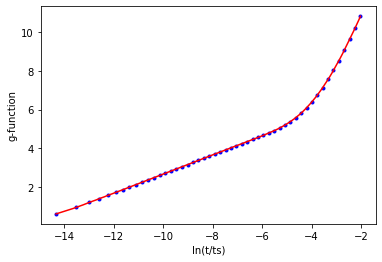

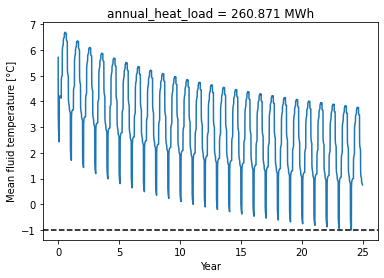

In [ ]:
if __name__ == "__main__":
    main()